In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io

class DataGenerator(torch.utils.data.Dataset):
    """
    Data generator for the m6A model. It randomly selects
    batches from the data to train the m6A model.
    """
    def __init__(self, features, labels, random_state=None):
        """
        Constructor for the data generator class, expects features
        and labels matrices.
        :param features: numpy.array, Nx15, N=number of sequences,
                                      each sequence is of length 15.
        :param labels: numpy array, one hot encoded labels for whether
                                    a sequence in features variable contains
                                    methylated A or not.
        :param random_state: numpy.random_state, allow reproducibility by selecting
                                                 a seed for random operations beforehand.
        """
        self.random_state = random_state
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Get random indices from the training data
        to form batches.
        :param idx: numpy.array, indices to retrieve, ignoring for now.
        :return: x, y: features and labels from selected indices.
        """
        i = self.random_state.choice(len(self.features))

        x = self.features[i]
        y = self.labels[i]

        x = torch.tensor(x)
        y = torch.tensor(y)

        return x, y


def m6AGenerator(data_path, random_state=None, pin_memory=True,
                 num_workers=0, batch_size=32):
    """
    This generator returns a training data generator as well as
    validation features and labels
    :param data_path: str, path where the data matrix is stored.
    :param random_state: int, seed for numpy random_state.
    :param pin_memory: bool, Makes CUDA efficient by skipping one copy
                             operation, true by default.
    :param num_workers: int, number of worker threads the generator can
                             utilize, 0 by default.
    :param batch_size: int, number of examples in each batch
    :return: X_gen: training data generator, X_val: validation features, y_val: validation labels
    """
    # initialize Random state
    random_state = np.random.RandomState(random_state)

    # Load training and validation data
    train_val_data = np.load(data_path, allow_pickle=True)

    # Get the dictionary from the containing relevant data
    train_val_data = train_val_data['save_data_dict'][()]

    # Load training and validation features and labels
    X_train = train_val_data['X_train']
    y_train = train_val_data['y_train']
    X_val = train_val_data['X_val']
    y_val = train_val_data['y_val']

    print(f"Training features shape {X_train.shape}, training labels shape: {y_train.shape}")
    print(f"Validation features shape {X_val.shape}, validation labels shape: {y_val.shape}")

    # Get the training data generator
    X_gen = DataGenerator(X_train,
                          y_train,
                          random_state=random_state)

    # Wrap it in a data loader
    X_gen = torch.utils.data.DataLoader(X_gen,
                                        pin_memory=pin_memory,
                                        num_workers=num_workers,
                                        batch_size=batch_size)

    return X_gen, (X_val, y_val)

/Users/mrvollger/miniconda3/envs/m6a-cpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train, (X_val, y_val) = m6AGenerator("m6A_train.npz", random_state=None, pin_memory=True, num_workers=2, batch_size=32)

Training features shape (255846, 7, 15), training labels shape: (255846, 2)
Validation features shape (85282, 7, 15), validation labels shape: (85282, 2)


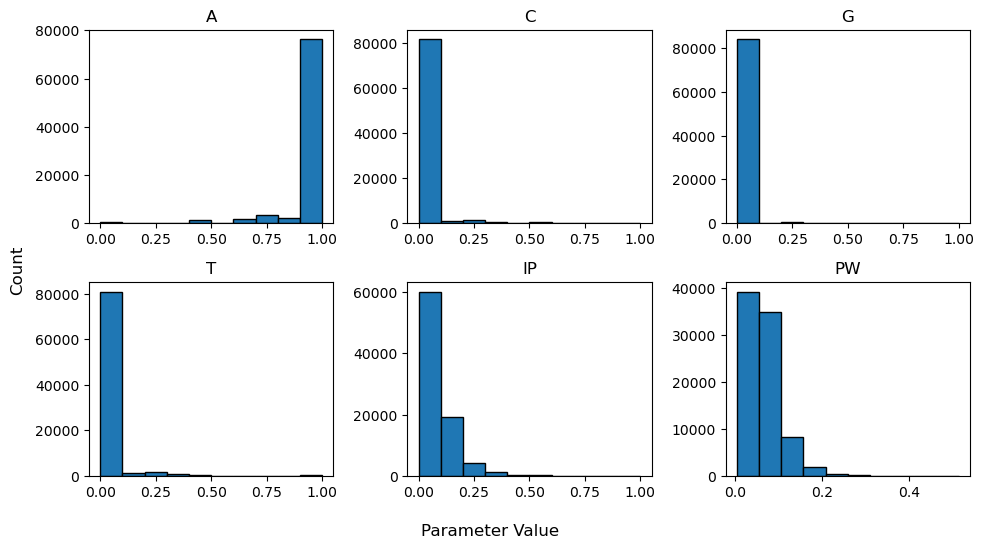

In [3]:
parameters = ['A', 'C', 'G', 'T', 'IP', 'PW']
fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
for i in range(6):
    axs.flat[i].hist(X_val[:, i, 7], edgecolor="black")
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supylabel("Count")
fig.supxlabel("Parameter Value")
fig.tight_layout()

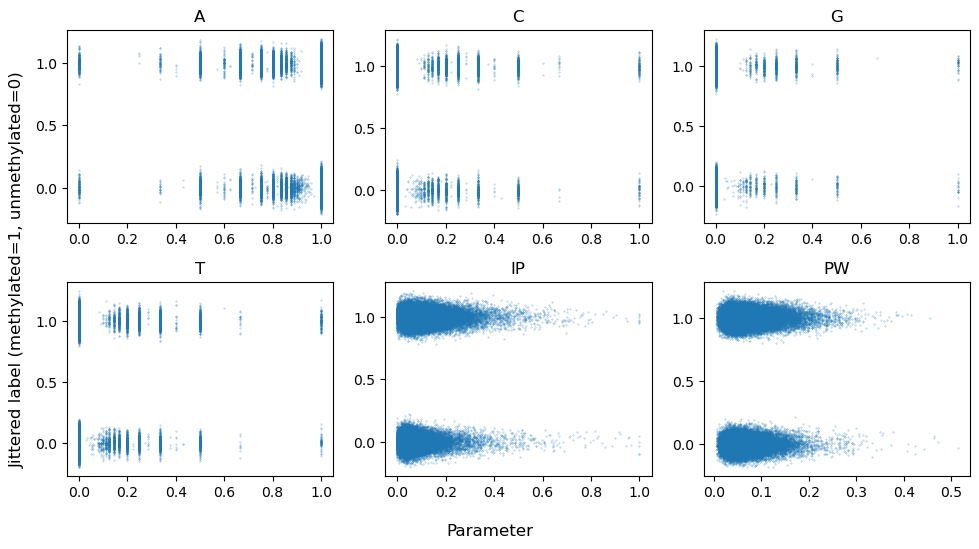

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
for i in range(6):
    axs.flat[i].scatter(X_val[:, i, 7], y_val[:, 0] + np.random.normal(loc=0, scale=.05, size=y_val[:, 0].shape), s=.1, alpha=.5)
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supxlabel("Parameter")
fig.supylabel("Jittered label (methylated=1, unmethylated=0)") 
fig.tight_layout()

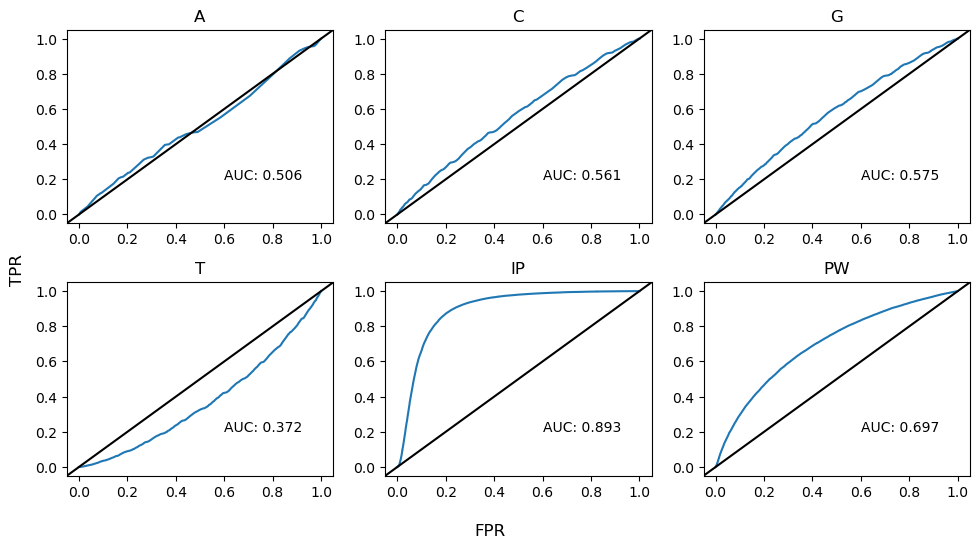

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
for i in range(6):
    fpr, tpr, thresholds = metrics.roc_curve(y_val[:, 0], np.sum(X_val[:, i, :], axis=1), pos_label=1)
    axs.flat[i].plot(fpr, tpr)
    axs.flat[i].axline([0,0], slope=1, c="black")
    axs.flat[i].text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supxlabel("FPR")
fig.supylabel("TPR")
fig.tight_layout()

In [3]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [32]:
X_val.shape[1] , X_val.shape[2], X_val.shape[1] * X_val.shape[2], X_val.shape[0]

(7, 15, 105, 85282)

In [117]:
losses = []
losses_test = []
Iterations = []
epochs = 25
training_loss = []
learning_rate = 0.0001

model = LogisticRegression(105, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    iteration = 0
    for batch in X_train:
        x = batch[0]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2]).float()
        labels = batch[1][:,0].float()
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 
        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        training_loss.append(loss.detach().numpy())
        iteration += 1
        if iteration % 10000 == 0 : print(iteration)
    y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
    y_obs = y_val[:, 0]
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    print(f"AUC: {metrics.auc(fpr, tpr)}")


Epoch: 0
AUC: 0.8642933828675027
Epoch: 1
AUC: 0.8900081345657908
Epoch: 2
AUC: 0.9015470124049979
Epoch: 3
AUC: 0.9072887868667232
Epoch: 4
AUC: 0.9105489094837773
Epoch: 5
AUC: 0.9126295822152012
Epoch: 6
AUC: 0.9140878104933263
Epoch: 7
AUC: 0.9151836842233072
Epoch: 8
AUC: 0.9160449224443983
Epoch: 9
AUC: 0.916748956943515
Epoch: 10
AUC: 0.9173356970840307
Epoch: 11
AUC: 0.9178334670584334
Epoch: 12
AUC: 0.9182622519911942
Epoch: 13
AUC: 0.9186363611186839
Epoch: 14
AUC: 0.9189634305060916
Epoch: 15
AUC: 0.9192508879110335
Epoch: 16
AUC: 0.9195063003386773
Epoch: 17
AUC: 0.9197331312195507
Epoch: 18
AUC: 0.9199345499858054
Epoch: 19
AUC: 0.9201141497316814
Epoch: 20
AUC: 0.9202750829766724
Epoch: 21
AUC: 0.9204196577348711
Epoch: 22
AUC: 0.9205480882332816
Epoch: 23
AUC: 0.9206651415865028
Epoch: 24
AUC: 0.9207732960627204


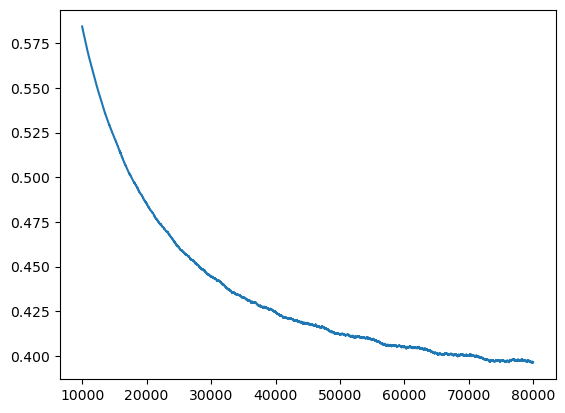

In [106]:
plt.plot(pd.Series(training_loss).rolling(10000).mean())

Text(0.6, 0.2, 'AUC: 0.917')

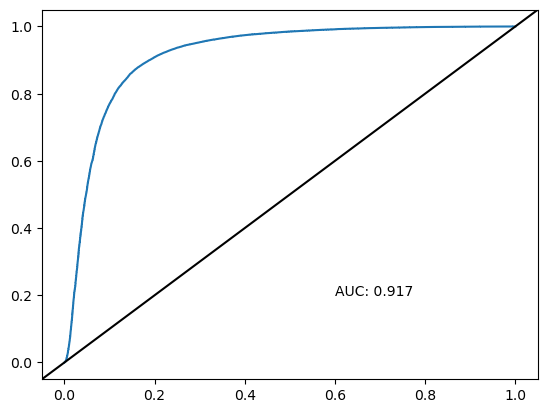

In [112]:
y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
y_obs = y_val[:, 0]
fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.axline([0,0], slope=1, c="black")
plt.text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 

In [115]:
confusion_raw = metrics.confusion_matrix(y_obs, y_pred>0.5) 
confusion_percent = np.transpose(confusion_raw.transpose()/confusion_raw.sum(axis=1)*100)
confusion_raw, confusion_percent, np.array([["TN", "FP"], ["FN", "TP"]] )

(array([[29929,  6046],
        [ 5784, 43523]]),
 array([[83.19388464, 16.80611536],
        [11.73058592, 88.26941408]]),
 array([['TN', 'FP'],
        ['FN', 'TP']], dtype='<U2'))

In [116]:
y_pred

array([[0.24045686],
       [0.9875709 ],
       [0.11597106],
       ...,
       [0.0723804 ],
       [0.27577507],
       [0.941585  ]], dtype=float32)